In [1]:
%matplotlib inline
from config_calc import *
import grid_tools

from collections import OrderedDict

import cesm_orcas_sci as cesm
import cam
import gv
import metpy.calc as mcalc

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [5]:
reload(cesm)
case = 'bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004'

tracer_def = cesm.trace_gas_tracers(case)
tracer_3d = [k for k in tracer_def]
varlist = ['CO2']

ds = cesm.open_casedata(case,'atm','cam.h0',varlist,transformed='z3')

ds = ds.sel(time=slice('2016-01-15','2016-02-29'))
ds = cesm.convert_dataset(ds,case)

print('ds size {:0.2f}GB\n'.format(ds.nbytes / 1e9))
ds.info()

ds size 1.14GB

xarray.Dataset {
dimensions:
	lat = 192 ;
	lon = 288 ;
	time = 46 ;
	zlev = 56 ;

variables:
	float64 lat(lat) ;
		lat:long_name = latitude ;
		lat:units = degrees_north ;
	float64 lon(lon) ;
		lon:long_name = longitude ;
		lon:units = degrees_east ;
	datetime64[ns] time(time) ;
		time:long_name = time ;
		time:bounds = time_bnds ;
	float64 CO2(time, zlev, lat, lon) ;
		CO2:units = ppmv ;
		CO2:long_name = CO2 ;
	float64 plev(zlev) ;
		plev:units = m ;
		plev:long_name = Geopotential height (above sea level) ;

// global attributes:
}

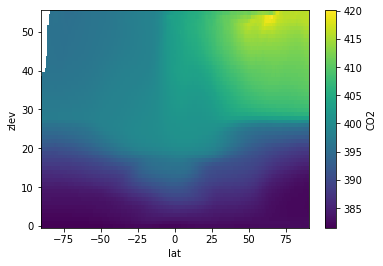

In [6]:
ds.CO2.mean(dim=['time','lon']).plot()

In [24]:
area = grid_tools.compute_grid_area(ds.lon.values,ds.lat.values)
landfrac = xr.open_dataset('/glade/p/work/mclong/grids/f09_f09.nc')['LANDFRAC'].isel(time=0)
landfrac

total area = 5.1008244881083744e+14
check area = 5.1009969907076156e+14


<xarray.DataArray 'LANDFRAC' (lat: 192, lon: 288)>
array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
    time     datetime64[ns] 2007-11-01
Attributes:
    units:         fraction
    long_name:     Fraction of sfc area covered by land
    cell_methods:  time: mean

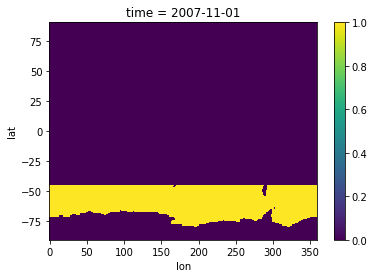

In [26]:
rmask = landfrac.where(landfrac<0.9).fillna(0.).where(landfrac>=0.9).fillna(1.).where(landfrac.lat<-44.).fillna(0.)
rmask.plot()

<xarray.DataArray (lat: 192, lon: 288)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
    time     datetime64[ns] 2007-11-01

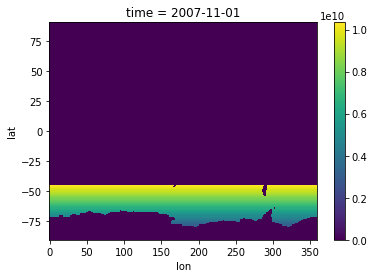

In [104]:
wgt = rmask * area
wgt = wgt.compute()
wgt.plot()
wgt

In [105]:
%%time
ravg = xr.Dataset()
for v in varlist:
    ravg[v] = (ds[v] * wgt).sum(dim=['lat','lon']) / wgt.where(ds[v].notnull()).sum(dim=['lat','lon'])
print ravg

<xarray.Dataset>
Dimensions:  (time: 46, zlev: 56)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-15 2016-01-16 2016-01-17 ...
    plev     (zlev) float64 4.248e+04 4.079e+04 3.916e+04 3.759e+04 ...
Dimensions without coordinates: zlev
Data variables:
    CO2      (time, zlev) float64 381.6 381.9 382.1 382.4 382.7 383.0 383.1 ...
CPU times: user 3.54 s, sys: 1.49 s, total: 5.04 s
Wall time: 5.04 s


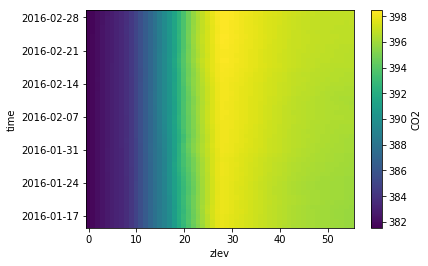

In [106]:
ravg.CO2.plot()

(395, 399)

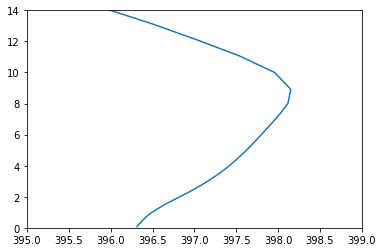

In [111]:
plt.plot(ravg.CO2.mean(dim='time'),ravg.plev*1e-3)
plt.gca().set_ylim([0,14])
plt.gca().set_xlim([395,399])

(394.6728015458445, 401.7515578139691)

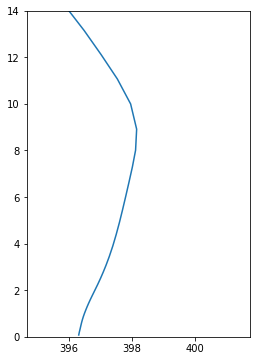

In [115]:
fig = plt.figure(figsize=(4.,6.))
ax = fig.add_subplot(111)
sc = ax.plot(ravg.CO2.mean(dim='time'),ravg.plev*1e-3)
ax.set_ylim([0,14])
ax.set_xlim(394.67280154584449, 401.7515578139691)

In [118]:
file_out = os.path.join(diro['out'],'.'.join([case,'so-ocean-mean-campaign','nc']))
ravg.to_netcdf(file_out)                        

In [121]:
ravg.time

<xarray.DataArray 'time' (time: 46)>
array(['2016-01-15T00:00:00.000000000', '2016-01-16T00:00:00.000000000',
       '2016-01-17T00:00:00.000000000', '2016-01-18T00:00:00.000000000',
       '2016-01-19T00:00:00.000000000', '2016-01-20T00:00:00.000000000',
       '2016-01-21T00:00:00.000000000', '2016-01-22T00:00:00.000000000',
       '2016-01-23T00:00:00.000000000', '2016-01-24T00:00:00.000000000',
       '2016-01-25T00:00:00.000000000', '2016-01-26T00:00:00.000000000',
       '2016-01-27T00:00:00.000000000', '2016-01-28T00:00:00.000000000',
       '2016-01-29T00:00:00.000000000', '2016-01-30T00:00:00.000000000',
       '2016-01-31T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-02-02T00:00:00.000000000', '2016-02-03T00:00:00.000000000',
       '2016-02-04T00:00:00.000000000', '2016-02-05T00:00:00.000000000',
       '2016-02-06T00:00:00.000000000', '2016-02-07T00:00:00.000000000',
       '2016-02-08T00:00:00.000000000', '2016-02-09T00:00:00.000000000',
       '2016-0